In [57]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from collections import defaultdict
import networkx as nx
from math import comb
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
from itertools import repeat
from tqdm.auto import tqdm
import pandas as pd
from components import increasing_components

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

In [4]:
from dgl.data import TUDataset
from dgl import to_networkx
from dgl.data import MiniGCDataset

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
# X = pd.read_pickle('X.pkl')
# y = pd.read_pickle('y.pkl')

In [6]:
def PPprobs(Graph, iters):
    G = nx.from_numpy_array(Graph)
    L = nx.line_graph(G)
    edges = np.array(L.nodes())
    B = nx.to_numpy_array(L)
    C= B.copy()
    #C = C + np.diag(np.ones(len(C)))
    for i in range(len(C)):
        if C[i].sum() == 0:
            C[i][i] = 1
        else:
            C[i]=C[i]/(C[i].sum())
    C=np.transpose(C)
    retprobs = np.diag(np.linalg.matrix_power(C, iters))
    times = []
    for i in range(len(retprobs)):
        els = set()
        for j in retprobs:
            if j < retprobs[i]:
                els.add(j)
        times.append(len(els))

    n = max(Graph[i].sum() for i in range(len(Graph)))
    V = len(Graph)
    PPP = np.poly1d([])
    PPQ = np.poly1d([])

    Graphi = np.zeros(V*V).reshape(V,V)
    left = V
    cycles = 0
    i = 0
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    if len(times)>0:
        for tau in range(max(times)+1):
            i_indexes = get_indexes(i, times)

            for edge in i_indexes:

                Graphi[edges[edge][0], edges[edge][1]] = 1
                Graphi[edges[edge][1], edges[edge][0]] = 1

            comps = connected_components(Graphi)[0]
            PPP[i] = left - comps
            left = left - (left - comps)
            PPQ[i] = Graphi.sum()/2 - V + comps - cycles
            cycles = Graphi.sum()/2 - V + comps
            i += 1
    PPP[i] = left
    PPP = tuple(PPP)
    PPQ = list(PPQ)
    for i in range(len(PPQ)):
        if PPQ[0] == 0:
            PPQ = PPQ[1:]
    PPQ = tuple(PPQ)
    polys = (PPP, PPQ)
    return polys, Graph

In [7]:
def PPfromrandict(Graph, state):
    k = len(Graph)-2
    arr = np.arange(int((k+2)*(k+1)/2))
    np.random.seed(state)
    np.random.shuffle(arr)
    dicof = {}
    t = 0
    for a in range(1, k+2):
        for b in range(1, a+1):
            dicof[arr[t]] = [a, b]
            t += 1
    n = max(Graph[i].sum() for i in range(len(Graph)))
    V = len(Graph)
    PPP = np.poly1d([])
    PPQ = np.poly1d([])
    Graphi = np.zeros(V*V).reshape(V,V)
    left = V
    cycles = 0
    i = 0
    while np.array_equal(Graphi, Graph) == 0: 
        for a in range(V):
            for b in range(V):
                macs = max(Graph[a].sum(), Graph[b].sum())
                mi = min(Graph[a].sum(), Graph[b].sum())
                if dicof[i] == [macs, mi]:
                    Graphi[a][b] = Graph[a][b]

        comps = connected_components(Graphi)[0]
        PPP[i] = left - comps
        left = left - (left - comps)
        PPQ[i] = Graphi.sum()/2 - V + comps - cycles
        cicles = Graphi.sum()/2 - V + comps
        i += 1 
    PPP[i] = left
    PPP = tuple(PPP)
    PPQ = list(PPQ)
    for i in range(len(PPQ)):
        if PPQ[0] == 0:
            PPQ = PPQ[1:]
    PPQ = tuple(PPQ)
    polys = (PPP, PPQ)
    return polys, Graph

In [33]:
adj_matrices = []
for i in range(2, 10):
    g6_name = f'graph{i}.g6'
    adj_name = f'graph{i}.adj'
    link = f'https://users.cecs.anu.edu.au/~bdm/data/{g6_name}'
    !wget -cq $link
    !./showg -Aq $g6_name $adj_name
    adj_matrices.append(np.loadtxt(adj_name, dtype = int).reshape(-1, i, i))

/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied
/bin/bash: line 1: ./showg: Permission denied


FileNotFoundError: graph10.adj not found.

In [8]:
adj_matrices

[array([[[0, 0],
         [0, 0]],
 
        [[0, 1],
         [1, 0]]]),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 1],
         [0, 0, 0],
         [1, 0, 0]],
 
        [[0, 0, 1],
         [0, 0, 1],
         [1, 1, 0]],
 
        [[0, 1, 1],
         [1, 0, 1],
         [1, 1, 0]]]),
 array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [1, 1, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 0]],
 
        [[0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 1, 0, 0]],
 
        [[0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 0, 1],
         [1, 0, 1, 0]],
 
        [[0, 0, 1, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [1, 1, 0, 0]],
 
        [

In [8]:
def PPbij(Graph):
 n = max(Graph[i].sum() for i in range(len(Graph)))
 V = len(Graph)
 PPP = np.poly1d([])
 PPQ = np.poly1d([])

 Graphi = np.zeros(V*V).reshape(V,V)
 left = V
 cycles = 0
 i = 0
 while np.array_equal(Graphi, Graph) == 0:
     for a in range(V):
         for b in range(V):
             macs = max(Graph[a].sum(), Graph[b].sum())
             mi = min(Graph[a].sum(), Graph[b].sum())
             if int(macs*(macs-1)/2) + mi == i:
                 Graphi[a][b] = Graph[a][b]
     comps = connected_components(Graphi)[0]
     PPP[i] = left - comps
     left = left - (left - comps)
     PPQ[i] = Graphi.sum()/2 - V + comps - cycles
     cycles = Graphi.sum()/2 - V + comps
     i += 1
 PPP[i] = left
 PPP = tuple(PPP)
 PPQ = list(PPQ)
 for i in range(len(PPQ)):
     if PPQ[0] == 0:
         PPQ = PPQ[1:]
 PPQ = tuple(PPQ)
 polys = (PPP, PPQ)
 return polys, Graph


In [55]:

def PPfastprobs(Graph, iters):
    if isinstance(Graph, np.ndarray):
        G = nx.from_numpy_array(Graph)
    else:
        G = Graph
    L = nx.line_graph(G)
    edges = np.array(L.nodes())
    C = nx.to_numpy_array(L)
    #C = C + np.diag(np.ones(len(C)))
    
    C[np.diag(np.all(C==0, axis=0))]=1
    C=C/C.sum(axis=0)
    
    Matprobs=C.copy()
    
    allpolys=[]
    for k in range(iters):
        times = []
        retprobs = np.diag(Matprobs)
        for i in range(len(retprobs)):
            els = set()
            for j in retprobs:
                if j < retprobs[i]:
                    els.add(j)
            times.append(len(els))
        times = np.array(times, dtype=np.int32)
        PPP, PPQ  = increasing_components(G.number_of_nodes(), *(edges[times == i] for i in range(times.max(initial=-1) + 1)))
        # PPP = np.poly1d(PPP, dtype=np.uint8)
        # PPQ = np.poly1d(PPQ, dtype=np.uint8)
        PPP = np.array(PPP, dtype=np.uint8)
        PPQ = np.array(PPQ, dtype=np.uint8)
       
        PPP = tuple(PPP)
        PPQ = list(PPQ)
        for i in range(len(PPQ)):
            if PPQ[0] == 0:
                PPQ = PPQ[1:]
        PPQ = tuple(PPQ)
        polys = (PPP, PPQ)
        allpolys.append(polys)
        Matprobs=np.matmul(Matprobs,C)
    return tuple(allpolys), Graph

def job(i, maxdeg):

    polyslist = []
    # polys, Graph = PPbij(i)
    # polyslist.append(polys)
    
    # for t in []:
    #     polys, Graph = PPfromrandict(i, t)
    #     polyslist.append(polys)
    
    polys, Graph = PPfastprobs(i, maxdeg)
    polyslist.append(polys)
    
    counts = np.unique(sum(i), return_counts=True)
    coord = 0
    for t in range(len(i)):
        if len(counts[0]) > coord:
            if counts[0][coord]==t:
                polyslist.append(counts[1][coord])
                coord += 1
            else:
                polyslist.append(0)
        else: 
            polyslist.append(0)
        
        
    polyslist = tuple((polyslist))
    # for t in range(2, 100):
    #     polys, Graph = PPprobs(i, t)
    #     polyslist.append(polys)
    
    return polyslist, i

In [56]:
%%time
for j in np.arange(2,3):

    Polynomials = defaultdict(list)
    for a, b in process_map(job, adj_matrices[j], repeat(3), chunksize=max(1, int(len(adj_matrices[j])/100))):
        Polynomials[a].append(b)

        
        
    print('From ' + str(len(adj_matrices[j])) + ' graphs on', j+2, 'vertices')
    negprob = 0
    for i in Polynomials:
        negprob += comb(len(Polynomials[i]), 2)
    print('number of equivalence classes is ' + str(len(Polynomials)) )
    print('probability to distinguish two random graphs from dataset is ' + str(1 - negprob/comb(len(adj_matrices[j]), 2)))


  0%|          | 0/11 [00:00<?, ?it/s]

From 11 graphs on 4 vertices
number of equivalence classes is 11
probability to distinguish two random graphs from dataset is 1.0
CPU times: user 14 ms, sys: 1.55 s, total: 1.56 s
Wall time: 1.8 s


In [11]:
Graphsleft=[]
for i in Polynomials:
    if len(Polynomials[i])>1:
        for g in Polynomials[i]:
            Graphsleft.append(g)

In [28]:
print(len(Graphsleft))
Polynomials = defaultdict(list)
for a, b in process_map(job, Graphsleft, repeat(102), chunksize=max(1, int(len(Graphsleft)/100))):
    Polynomials[a].append(b)



print('From ' + str(len(Graphsleft)) + ' graphs on', j+2, 'vertices')
negprob = 0
for i in Polynomials:
    negprob += comb(len(Polynomials[i]), 2)
print('number of equivalence classes is ' + str(len(Polynomials)) )
print('probability to distinguish two random graphs from dataset is ' + str(1 - negprob/comb(len(Graphsleft), 2)))

1389


  0%|          | 0/1389 [00:00<?, ?it/s]

From 1389 graphs on 9 vertices
number of equivalence classes is 1389
probability to distinguish two random graphs from dataset is 1.0


In [194]:
for i in Polynomials:
    if len(Polynomials[i]) > 1:
        print(Polynomials[i])

[array([[0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0]]), array([[0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0]])]


In [203]:
np.sort(np.unique(sum(np.array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0]])), return_counts=True)[0])

array([0, 1, 2])

In [205]:
np.unique([10, 100, 2, 57,57 , 69])

array([  2,  10,  57,  69, 100])

In [253]:
%%writefile minigccreate.py
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse.csgraph import connected_components
from tqdm.contrib.concurrent import process_map
from itertools import repeat
from tqdm.auto import tqdm
from dgl.data import MiniGCDataset

def PPfromrandict(Graph, state):
    k = len(Graph)-2
    arr = np.arange(int((k+2)*(k+1)/2))
    np.random.seed(state)
    np.random.shuffle(arr)
    dicof = {}
    t = 0
    for a in range(1, k+2):
        for b in range(1, a+1):
            dicof[arr[t]] = [a, b]
            t += 1
    n = max(Graph[i].sum() for i in range(len(Graph)))
    V = len(Graph)
    PPP = np.poly1d([])
    PPQ = np.poly1d([])
    Graphi = np.zeros(V*V).reshape(V,V)
    left = V
    cycles = 0
    i = 0
    while np.array_equal(Graphi, Graph) == 0: 
        for a in range(V):
            for b in range(V):
                macs = max(Graph[a].sum(), Graph[b].sum())
                mi = min(Graph[a].sum(), Graph[b].sum())
                if dicof[i] == [macs, mi]:
                    Graphi[a][b] = Graph[a][b]

        comps = connected_components(Graphi)[0]
        PPP[i] = left - comps
        left = left - (left - comps)
        PPQ[i] = Graphi.sum()/2 - V + comps - cycles
        cicles = Graphi.sum()/2 - V + comps
        i += 1 
    PPP[i] = left
    PPP = tuple(PPP)
    PPQ = list(PPQ)
    for i in range(len(PPQ)):
        if PPQ[0] == 0:
            PPQ = PPQ[1:]
    PPQ = tuple(PPQ)
    polys = (PPP, PPQ)
    return polys, Graph

def PPfastprobs(Graph, iters):
    G = nx.from_numpy_array(Graph)
    L = nx.line_graph(G)
    edges = np.array(L.nodes())
    B = nx.to_numpy_array(L)
    C= B.copy()
    #C = C + np.diag(np.ones(len(C)))
    for i in range(len(C)):
        if C[i].sum() == 0:
            C[i][i] = 1
        else:
            C[i]=C[i]/(C[i].sum())
    C=np.transpose(C)
    Matprobs=C.copy()
    allpolys=[]
    for k in range(iters):
        times = []
        retprobs = np.diag(Matprobs)
        for i in range(len(retprobs)):
            els = set()
            for j in retprobs:
                if j < retprobs[i]:
                    els.add(j)
            times.append(len(els))

        n = max(Graph[i].sum() for i in range(len(Graph)))
        V = len(Graph)
        PPP = np.poly1d([])
        PPQ = np.poly1d([])

        Graphi = np.zeros(V*V).reshape(V,V)
        left = V
        cycles = 0
        i = 0
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        if len(times)>0:
            for tau in range(max(times)+1):
                i_indexes = get_indexes(i, times)

                for edge in i_indexes:

                    Graphi[edges[edge][0], edges[edge][1]] = 1
                    Graphi[edges[edge][1], edges[edge][0]] = 1

                comps = connected_components(Graphi)[0]
                PPP[i] = left - comps
                left = left - (left - comps)
                PPQ[i] = Graphi.sum()/2 - V + comps - cycles
                cycles = Graphi.sum()/2 - V + comps
                i += 1
        PPP[i] = left
        PPP = tuple(PPP)
        PPQ = list(PPQ)
        for i in range(len(PPQ)):
            if PPQ[0] == 0:
                PPQ = PPQ[1:]
        PPQ = tuple(PPQ)
        polys = (PPP, PPQ)
        allpolys.append(polys)
        Matprobs=np.matmul(Matprobs,C)
    return tuple(allpolys), Graph

def job(i):

    polyslist = []
    polys, Graph = PPbij(i)
    polyslist.append(polys)
    
    for t in []:
        polys, Graph = PPfromrandict(i, t)
        polyslist.append(polys)
    
    polys, Graph = PPfastprobs(i, 65)
    polyslist.append(polys)
    polyslist = tuple((polyslist))
    
    # for t in range(2, 100):
    #     polys, Graph = PPprobs(i, t)
    #     polyslist.append(polys)
    
    return polyslist, i

def treatment(datachunk, seedsfordicts, maxdegforretprobs):
    g, label = datachunk
    target = int(label)
    #g = nx.to_numpy_array(to_networkx(g))
    g = g - np.diag(np.diag(g))
    features = createfeatures(g, seedsfordicts, maxdegforretprobs)
    return target, features
    
def createfeatures(graph, seedsfordicts, maxdegforretprobs):
    polyslist = []
    for t in seedsfordicts:
        polys, Graph = PPfromrandict(graph, t)
        polyslist.append(polys)
    
    # for t in range(1, maxdegforretprobs):
    #     polys, Graph = PPprobs(graph, t)
    #     polyslist.append(polys)

    polys, Graph = PPfastprobs(graph, maxdegforretprobs-1)

    for t in range(len(polys)):
        polyslist.append(list(polys)[t])
    return polyslist

def createMiniGCDataset(numofgraphs, minnumofnodes, maxnumofnodes, seedfordata, seedsfordicts, maxdegforretprobs):
    data = MiniGCDataset(numofgraphs, minnumofnodes, maxnumofnodes, save_graph = False, seed=seedfordata, transform=lambda g: g.adj(scipy_fmt='coo').toarray())


    dataset = process_map(treatment, data, repeat(seedsfordicts), repeat(maxdegforretprobs), chunksize = 7 , max_workers=1)
    targets, allfeatures = zip(*dataset)


    dfs = []
    for i, poly in enumerate(zip(*allfeatures)):
        x, y = zip(*poly)
        dfs.append(pd.DataFrame(map(reversed, x)).add_prefix(f'poly_{i}/x^'))
        dfs.append(pd.DataFrame(map(reversed, y)).add_prefix(f'poly_{i}/y^'))
    return pd.concat(dfs, axis=1).fillna(0), targets
if __name__ == '__main__':
    X, y = createMiniGCDataset(2000, 6, 200, 57, [], 6)
    X['target'] = y
    X.to_pickle('X.pkl')
    

Overwriting minigccreate.py


In [312]:


def treatment(datachunk, seedsfordicts, maxdegforretprobs):
    g, label = datachunk
    target = int(label)
    #g = nx.to_numpy_array(to_networkx(g))
    g = g - np.diag(np.diag(g))
    features = createfeatures(g, seedsfordicts, maxdegforretprobs)
    return target, features
    
def createfeatures(graph, seedsfordicts, maxdegforretprobs):
    polyslist = []

    for t in seedsfordicts:
        polys, Graph = PPfromrandict(graph, t)
        polyslist.append(polys)

        
    degs = []
    counts = np.unique(sum(graph), return_counts=True)
    coord = 0
    for t in range(len(graph)):
        if len(counts[0]) > coord:
            if counts[0][coord]==t:
                degs.append(counts[1][coord])
                coord += 1
            else:
                degs.append(0)
        else: 
            degs.append(0)
    degpoly = tuple((tuple(degs), tuple()))
    polyslist.append(degpoly)  
    # polys, Graph = PPbij(graph)
    # polyslist.append(polys)
    # for t in range(1, maxdegforretprobs):
    #     polys, Graph = PPprobs(graph, t)
    #     polyslist.append(polys)

    polys, Graph = PPfastprobs(graph, maxdegforretprobs-1)

    for t in range(len(polys)):
        polyslist.append(list(polys)[t])
    return polyslist

def createMiniGCDataset(numofgraphs, minnumofnodes, maxnumofnodes, seedfordata, seedsfordicts, maxdegforretprobs):
    data = MiniGCDataset(numofgraphs, minnumofnodes, maxnumofnodes, save_graph = False, seed=seedfordata, transform=lambda g: g.adj(scipy_fmt='coo').toarray())


    dataset = process_map(treatment, data, repeat(seedsfordicts), repeat(maxdegforretprobs), chunksize = int(numofgraphs/100)+1, max_workers=5)
    targets, allfeatures = zip(*dataset)


    dfs = []
    for i, poly in enumerate(zip(*allfeatures)):
        x, y = zip(*poly)
        dfs.append(pd.DataFrame(map(reversed, x)).add_prefix(f'poly_{i}/x^'))
        dfs.append(pd.DataFrame(map(reversed, y)).add_prefix(f'poly_{i}/y^'))
    return pd.concat(dfs, axis=1).fillna(0), targets

        
        
    

In [313]:
 X, y = createMiniGCDataset(1000, 6, 129, 57, [], 5)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
data = MiniGCDataset(300, 6, 100, save_graph = False, seed=57, transform=lambda g: g.adj(scipy_fmt='coo').toarray())

In [99]:

graph = data[200][0]
graph = graph - np.diag(np.diag(graph))
maxdegforretprobs = 10
polyslist = []

for t in range(1, maxdegforretprobs):
    polys, Graph = PPprobs(graph, t)
    polyslist.append(polys)
print(polyslist)
print(len(polyslist))
polyslist = []

polys, Graph = PPfastprobs(graph, maxdegforretprobs-1)

for t in range(len(polys)):
    polyslist.append(list(polys)[t])
print(polyslist)
print(len(polyslist))
print('----------------------------')

[((1.0, 19.0), (9.0,)), ((1.0, 4.0, 0.0, 4.0, 11.0), (2.0, 2.0, 0.0, 5.0)), ((1.0, 0.0, 2.0, 11.0, 4.0, 2.0), (2.0, 2.0, 5.0, 0.0, 0.0)), ((1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 4.0, 6.0), (2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0)), ((1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 3.0, 6.0, 4.0, 2.0), (2.0, 1.0, 1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0), (2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0), (1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((1.0, 0.0, 0.0, 1.0, 1.0, 3.0, 1.0, 2.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0), (2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 1.0, 4.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0),

In [301]:
X['target'] = y

In [303]:
X.drop_duplicates(inplace=True)

In [305]:
y = X.target
X = X.drop(columns = ['target'])

In [304]:
X.shape

(355, 174)

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0x575757, stratify=y)

In [307]:
%%time
gradboost = GradientBoostingClassifier()
meanacc=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    gradboost.fit(X_train, y_train)
    #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
    meanacc.append(accuracy_score(y_test, gradboost.predict(X_test)))
print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)

98.13084112149532 +- 0.9345794392523366
CPU times: user 9.24 s, sys: 358 µs, total: 9.24 s
Wall time: 9.24 s


In [162]:
importances = {}
num = 0
for i in X.columns:

    importances[i] = gradboost.feature_importances_[num]
    num+=1


In [165]:
thresh= 0.015
valuable= {}
for i in importances:
    if importances[i]>thresh:
        valuable[i]=importances[i]

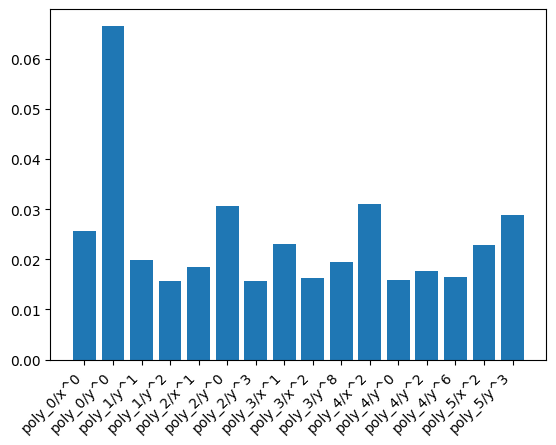

In [166]:
names = list(valuable.keys())
values = list(valuable.values())
fig, ax = plt.subplots()
plt.bar(range(len(valuable)), values, tick_label=names)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()


In [119]:
%%time
gsboost = GridSearchCV(gradboost, param_grid={'n_estimators': np.arange(100, 145, 1), 'max_depth': [1, 2, 3], 'learning_rate': np.arange(0.09, 0.12, 0.01)}, scoring='accuracy', cv=KFold(n_splits=7, shuffle=True, random_state=0x575757), n_jobs=-1)
gsboost.fit(X_train, y_train)
print(gsboost.best_estimator_)
print(accuracy_score(y_test, gsboost.best_estimator_.predict(X_test)), accuracy_score(y_train, gsboost.best_estimator_.predict(X_train)))

KeyboardInterrupt: 

In [48]:
accuracy_score(y_test, gsboost.best_estimator_.predict(X_test))

0.9974160206718347

In [32]:
y.value_counts()

3    426
5    234
2    140
0    137
1    137
6    137
7     71
4      6
Name: target, dtype: int64

In [35]:
lregpipe = Pipeline([('Poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
lregpipe.fit(X_train, y_train)
print(accuracy_score(y_test, lregpipe.predict(X_test)), accuracy_score(y_train, lregpipe.predict(X_train)))

0.937984496124031 0.9833518312985572


In [66]:
print('Best model:', gslreg.best_estimator_)
print('Best score:', gslreg.best_score_)

Best model: Pipeline(steps=[('Poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=13, max_iter=10000, multi_class='ovr'))])
Best score: 0.8626179245283019


In [65]:
%%time
lregpipe = Pipeline([('Poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
gslreg = GridSearchCV(lregpipe, param_grid={'Poly__degree': np.arange(1, 3, 1), 'model__C': np.arange(1, 20, 1)}, scoring='accuracy', cv=KFold(n_splits=8, shuffle=True, random_state=0x575757), n_jobs=-1)
gslreg.fit(X_train, y_train)

CPU times: user 57.1 s, sys: 2min 12s, total: 3min 10s
Wall time: 1min 5s


GridSearchCV(cv=KFold(n_splits=8, random_state=5723991, shuffle=True),
             estimator=Pipeline(steps=[('Poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           multi_class='ovr'))]),
             n_jobs=-1,
             param_grid={'Poly__degree': array([1, 2]),
                         'model__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='accuracy')

In [67]:
print('test score:', gslreg.best_estimator_.score(X_test, y_test), 'train score:', gslreg.best_estimator_.score(X_train, y_train))

test score: 0.8791208791208791 train score: 0.9360189573459715


In [15]:
def treatment(datachunk, seedsfordicts, maxdegforretprobs):
    g, label = datachunk
    target = int(label)
    #g = nx.to_numpy_array(to_networkx(g))
    g = g - np.diag(np.diag(g))
    features = createfeatures(g, seedsfordicts, maxdegforretprobs)
    return target, features
    

def createfeatures(graph, seedsfordicts, maxdegforretprobs):
    polyslist = []
    # for t in seedsfordicts:
    #     polys, Graph = PPfromrandict(graph, t)
    #     polyslist.append(polys)
    
    # polys, Graph = PPbij(graph)
    # polyslist.append(polys)
    # for t in range(1, maxdegforretprobs):
    #     polys, Graph = PPprobs(graph, t)
    #     polyslist.append(polys)
    
    # degs = []
    # counts = np.unique(sum(graph), return_counts=True)
    # coord = 0
    # for t in range(len(graph)):
    #     if len(counts[0]) > coord:
    #         if counts[0][coord]==t:
    #             degs.append(counts[1][coord])
    #             coord += 1
    #         else:
    #             degs.append(0)
    #     else: 
    #         degs.append(0)
    # degpoly = tuple((tuple(degs), tuple()))
    # polyslist.append(degpoly)  
    

    polys, Graph = PPfastprobs(graph, maxdegforretprobs)

    for t in range(len(polys)):
        polyslist.append(list(polys)[t])
    return polyslist

def createTUDataset(name, seedsfordicts, maxdegforretprobs):
    data = TUDataset(name, transform=lambda g: g.adj(scipy_fmt='coo').toarray())



    dataset = process_map(treatment, data, repeat(seedsfordicts), repeat(maxdegforretprobs), chunksize = min(int(len(data)/50), 100))
    targets, allfeatures = zip(*dataset)


    dfs = []
    for i, poly in enumerate(zip(*allfeatures)):
        x, y = zip(*poly)
        dfs.append(pd.DataFrame(map(reversed, x)).add_prefix(f'poly_{i}/x^'))
        dfs.append(pd.DataFrame(map(reversed, y)).add_prefix(f'poly_{i}/y^'))
    return pd.concat(dfs, axis=1).fillna(0), targets


In [10]:
data = TUDataset('reddit_threads')

KeyboardInterrupt: 

In [137]:
data[0]

(Graph(num_nodes=47, num_edges=106,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(4,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'edge_labels': Scheme(shape=(1,), dtype=torch.int64)}),
 tensor([0]))

In [78]:
from pprint import pprint

In [139]:
print(PPfastprobs(nx.to_numpy_array(to_networkx(data[4][0])), 3))

((((1.0, 15.0), (2.0,)), ((1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 4.0, 1.0, 3.0, 2.0), (1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((1.0, 0.0, 0.0, 3.0, 1.0, 4.0, 4.0, 1.0, 2.0), (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0))), array([[0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
data = TUDataset('reddit_threads', transform=lambda g: g.adj(scipy_fmt='coo').toarray())

In [340]:
data

Dataset("AIDS", num_graphs=2000, save_path=/home/opl1do/.dgl/AIDS)

In [ ]:
X, y = createTUDataset('REDDIT-BINARY', [], 1)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [335]:
X.shape

(1500, 6265)

In [336]:
X

,poly_0/x^0,poly_0/x^1,poly_0/x^2,poly_0/x^3,poly_0/x^4,poly_0/x^5,poly_0/x^6,poly_0/x^7,poly_0/x^8,poly_0/x^9,...,poly_10/y^336,poly_10/y^337,poly_10/y^338,poly_10/y^339,poly_10/y^340,poly_10/y^341,poly_10/y^342,poly_10/y^343,poly_10/y^344,poly_10/y^345
0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,3,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,10,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0,0,4,0,0,0,3,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
gradboost = GradientBoostingClassifier()
meanacc=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    gradboost.fit(X_train, y_train)
    #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
    meanacc.append(accuracy_score(y_test, gradboost.predict(X_test)))
print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)

lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
meanacc=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    lregpipe.fit(X_train, y_train)
    #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
    meanacc.append(accuracy_score(y_test, lregpipe.predict(X_test)))
print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)

47.28888888888889 +- 1.5163308541539537
44.822222222222216 +- 1.3628220539077303


  0%|          | 0/1500 [00:00<?, ?it/s]

IMDB-MULTI 6
47.722222222222236 +- 1.7453642302672236
44.6888888888889 +- 1.3312947378444584
CPU times: user 3min 14s, sys: 2min 31s, total: 5min 45s
Wall time: 2min 13s


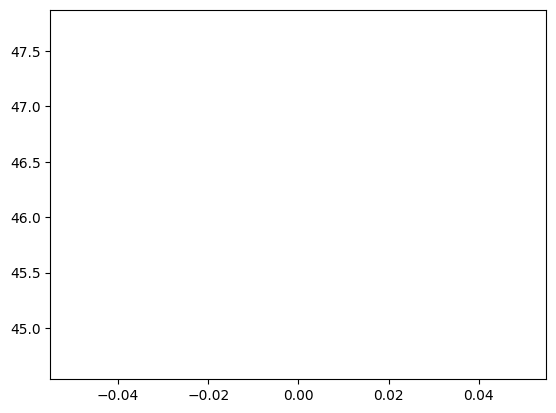

In [161]:
%%time
boostacc=[]
linacc=[]
for datas in ['IMDB-MULTI']:
    for deg in np.arange(6, 7):
        X, y = createTUDataset(datas, [], deg)
        print(datas, deg)
        gradboost = GradientBoostingClassifier()
        meanacc=[]
        for i in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
            gradboost.fit(X_train, y_train)
            #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
            meanacc.append(accuracy_score(y_test, gradboost.predict(X_test)))
        print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)
        boostacc.append(sum(meanacc) / len(meanacc)*100)
        
        lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
        meanacc=[]
        for i in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
            lregpipe.fit(X_train, y_train)
            #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
            meanacc.append(accuracy_score(y_test, lregpipe.predict(X_test)))
        print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)
        linacc.append(sum(meanacc) / len(meanacc)*100)
plt.plot(boostacc)
plt.plot(linacc)

In [146]:
%%time
lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
meanacc=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    lregpipe.fit(X_train, y_train)
    #print(accuracy_score(y_test, gradboost.predict(X_test)), accuracy_score(y_train, gradboost.predict(X_train)))
    meanacc.append(accuracy_score(y_test, lregpipe.predict(X_test)))
print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)


99.44166666666673 +- 0.30219107274114554
CPU times: user 18 s, sys: 31.9 s, total: 49.9 s
Wall time: 1.56 s


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [127]:
gradboost = GradientBoostingClassifier()
gsboost = GridSearchCV(gradboost, param_grid={'n_estimators': np.arange(10, 30), 'max_depth': [1, 2]}, scoring='accuracy', cv=KFold(n_splits=7, shuffle=True, random_state=0x575757), n_jobs=-1)
gsboost.fit(X_train, y_train)
print(gsboost.best_estimator_)

GradientBoostingClassifier(max_depth=1, n_estimators=26)


In [221]:
%%time

for foldnum in np.arange(7, 9):
    meanacc=[]
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        gsboost = GridSearchCV(gradboost, param_grid={'n_estimators': np.arange(40, 65), 'max_depth': [6, 7, 8, 9, 10, 11, 12]}, scoring='accuracy', cv=KFold(n_splits=foldnum, shuffle=True, random_state=0x575757), n_jobs=-1)
        gsboost.fit(X_train, y_train)
        print(gsboost.best_estimator_)
        meanacc.append(gsboost.best_estimator_.score(X_test, y_test))
    print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)

GradientBoostingClassifier(max_depth=12, n_estimators=46)
GradientBoostingClassifier(max_depth=6, n_estimators=46)
GradientBoostingClassifier(max_depth=6, n_estimators=48)
GradientBoostingClassifier(max_depth=10, n_estimators=42)
GradientBoostingClassifier(max_depth=6, n_estimators=41)
GradientBoostingClassifier(max_depth=6, n_estimators=56)
GradientBoostingClassifier(max_depth=10, n_estimators=44)
GradientBoostingClassifier(max_depth=7, n_estimators=42)
GradientBoostingClassifier(max_depth=12, n_estimators=53)
GradientBoostingClassifier(max_depth=7, n_estimators=51)
79.82456140350878 +- 3.4423538369032594
GradientBoostingClassifier(max_depth=8, n_estimators=43)
GradientBoostingClassifier(max_depth=7, n_estimators=40)
GradientBoostingClassifier(max_depth=6, n_estimators=57)
GradientBoostingClassifier(max_depth=6, n_estimators=43)
GradientBoostingClassifier(max_depth=6, n_estimators=64)
GradientBoostingClassifier(max_depth=8, n_estimators=44)
GradientBoostingClassifier(max_depth=7, n_es

In [170]:
X, y = createTUDataset('TRIANGLES', [], [1, 2, 3, 4, 5, 6])
X.shape

  0%|          | 0/45000 [00:00<?, ?it/s]

(45000, 1962)

In [53]:
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0x575757, test_size=0.3, stratify=y)
lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LinearSVC(penalty = 'l1', loss='squared_hinge', multi_class = 'ovr', tol = 1e-7,  max_iter = 100000, dual=False))])
lregpipe.fit(X_train, y_train)
print(accuracy_score(y_test, lregpipe.predict(X_test)), accuracy_score(y_train, lregpipe.predict(X_train)))

0.6167664670658682 0.9974326059050064


In [29]:
X['target']=y
cor_matrix = X.corr().abs()
print(cor_matrix['target'])

poly_0/x^0      0.056448
poly_0/x^1      0.094363
poly_0/x^2      0.091680
poly_0/x^3      0.102439
poly_0/x^4      0.066859
                  ...   
poly_3/y^353    0.031633
poly_3/y^354    0.031633
poly_3/y^355    0.031633
poly_3/y^356    0.031633
target          1.000000
Name: target, Length: 2865, dtype: float64


In [34]:
to_drop = [column for column in X.columns if cor_matrix['target'][column]<0.06]
print(len(to_drop))
X = X.drop(columns = to_drop, axis=1)

1843


In [13]:
# cor_matrix = X.corr().abs()
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype('bool'))

In [14]:
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
# print(len(to_drop))
# X = X.drop(columns = to_drop, axis=1)

1248


In [170]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
gslreg = GridSearchCV(lregpipe, param_grid={'model__C': np.arange(0.0001, 0.002, 0.0001)}, scoring='accuracy', cv=KFold(n_splits=7, shuffle=True, random_state=0x575757), n_jobs=-1)
gslreg.fit(X_train, y_train)
print('Best model:', gslreg.best_estimator_)
print('Best score:', gslreg.best_score_)
print('test score:', gslreg.best_estimator_.score(X_test, y_test), 'train score:', gslreg.best_estimator_.score(X_train, y_train))

Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.0005, max_iter=10000,
                                    multi_class='ovr'))])
Best score: 0.7356246552675125
test score: 0.7245508982035929 train score: 0.7394094993581515
CPU times: user 1.48 s, sys: 2.22 s, total: 3.7 s
Wall time: 5.74 s


In [231]:
%%time

meanacc=[]
for t in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    lregpipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 100000, tol=1e-7))])
    gslreg = GridSearchCV(lregpipe, param_grid={'model__C': np.arange(0.001, 0.5, 0.001)}, scoring='accuracy', cv=KFold(n_splits=7, shuffle=True), n_jobs=-1)
    gslreg.fit(X_train, y_train)
    #print('Best model:', gslreg.best_estimator_)
        # print('Best score:', gslreg.best_score_)
        # print('test score:', gslreg.best_estimator_.score(X_test, y_test), 'train score:', gslreg.best_estimator_.score(X_train, y_train))

            # lregpipe = Pipeline([('Poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('model', LogisticRegression(multi_class = 'ovr', max_iter = 10000))])
            # gslreg = GridSearchCV(lregpipe, param_grid={ 'model__C': np.arange(0.001, 1, 0.001)}, scoring='accuracy', cv=KFold(n_splits=8, shuffle=True, random_state=0x575757), n_jobs=-1)
            # gslreg.fit(X_train, y_train)
            # print('Best model:', gslreg.best_estimator_)
            # print('Best score:', gslreg.best_score_)
            # print('test score:', gslreg.best_estimator_.score(X_test, y_test), 'train score:', gslreg.best_estimator_.score(X_train, y_train))
    meanacc.append(gslreg.best_estimator_.score(X_test, y_test))
print(sum(meanacc) / len(meanacc)*100, '+-', np.std(meanacc)*100)

85.12280701754379 +- 4.087982824123571
CPU times: user 1min 40s, sys: 11.1 s, total: 1min 51s
Wall time: 2min 20s


tensor([5])


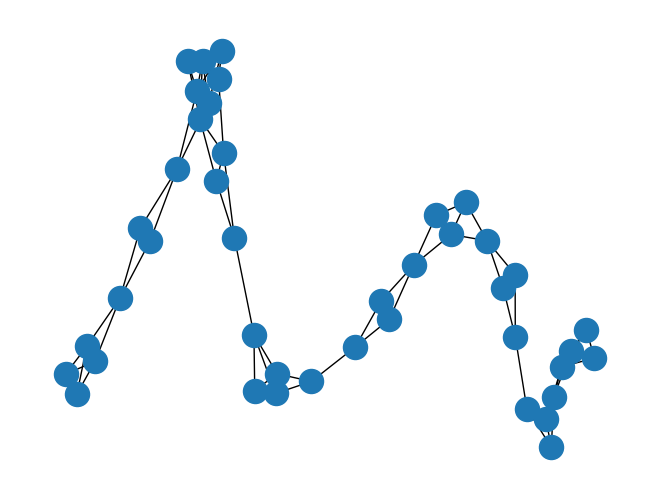

In [51]:
k = 12
print(data[k][1])
nx.draw(nx.from_numpy_array(data[k][0]))


In [313]:
len(data)

1178

In [10]:
from sympy import *
x, y, z = symbols("x y z")

In [11]:
expr=nx.chromatic_polynomial(nx.from_numpy_array(data[50][0]))

In [12]:
int(expr.subs(x, 3))

192

In [13]:
def toispowers(datachunk, i):
    g, label = datachunk
    target = int(label)
    g = g - np.diag(np.diag(g))
    expr=nx.chromatic_polynomial(nx.from_numpy_array(g))
    features=[]
    for k in range(i+1):
        features.append(int(expr.subs(x, k)))
    return target, features  



In [20]:
allfeats=[]
targets=[]
t=0
for datachunk in data:
    tar, feat = toispowers(datachunk, 5)
    allfeats.append(feat)
    targets.append(tar)
    print(t)
    t+=1


KeyboardInterrupt: 